In [21]:
import torch

In [22]:
from utils import assign_splits, get_label_mapping

# assign_splits(
#     file_path="faces_yolo_metadata.csv",
#     id_column="id",
#     label_column="mbti",
# )

mbti_to_idx = get_label_mapping(
    file_path="faces_yolo_id_split_metadata.csv",
    label_column="mbti",
)

for key in mbti_to_idx:
    if key.startswith("I"):
        mbti_to_idx[key] = 0
    else: 
        mbti_to_idx[key] = 1

print("MBTI to index mapping:", mbti_to_idx)

MBTI to index mapping: {'ENFJ': 1, 'ENFP': 1, 'ENTJ': 1, 'ENTP': 1, 'ESFJ': 1, 'ESFP': 1, 'ESTJ': 1, 'ESTP': 1, 'INFJ': 0, 'INFP': 0, 'INTJ': 0, 'INTP': 0, 'ISFJ': 0, 'ISFP': 0, 'ISTJ': 0, 'ISTP': 0}


In [23]:
from torchvision import transforms

train_tf = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(0.25, 0.25, 0.25, 0.05)], p=0.8),
        transforms.RandomApply(
            [
                transforms.RandomAffine(
                    degrees=10,  # small rotation
                    translate=(0.05, 0.05),  # small shifts
                    scale=(0.9, 1.1),
                )
            ],
            p=0.5,
        ),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.ToTensor(),
        transforms.RandomErasing(
            p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"
        ),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

val_tf = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [24]:
from torch.utils.data import DataLoader
from dataset import IDSplitCelebMBTIDataset

train_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    split="train",
    mbti_to_idx=mbti_to_idx,
    transform=train_tf,
)

val_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="val",
    transform=val_tf,
)

test_ds = IDSplitCelebMBTIDataset(
    root_dir="faces_yolo_id_split",
    metadata_csv="faces_yolo_id_split_metadata.csv",
    mbti_to_idx=mbti_to_idx,
    split="test",
    transform=val_tf,
)

print(len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print(images.shape)  # [Batch, 3, 224, 224]
    print(labels.shape)  # [Batch, 4]
    break

9573 1201 1205
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [25]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, num_classes),
)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [26]:
from tqdm import tqdm

train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(50):
    # training phase with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d} [train]", leave=False)
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)

        # print(logits.shape, y.shape)  # Debugging line
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)

        pbar.set_postfix(loss=loss.item())

    tr_loss = total_loss / total
    tr_acc = total_correct / total

    # validation phase with tqdm
    pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d} [val]", leave=False)
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            preds = logits.argmax(1)
            total_correct += (preds == y).sum().item()
            total_loss += loss.item() * y.size(0)
            total += y.size(0)

            pbar.set_postfix(loss=loss.item())

    va_loss = total_loss / total
    va_acc = total_correct / total

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f}/ train accuracy {tr_acc:.3f} | "
        f"val loss {va_loss:.4f}/ val accuracy {va_acc:.3f}"
    )

Epoch 00 | train loss 0.7564/ train accuracy 0.530 | val loss 0.6750/ val accuracy 0.585


Epoch 01 | train loss 0.7102/ train accuracy 0.563 | val loss 0.6822/ val accuracy 0.565


Epoch 02 | train loss 0.6909/ train accuracy 0.577 | val loss 0.6955/ val accuracy 0.571


Epoch 03 | train loss 0.6719/ train accuracy 0.609 | val loss 0.7026/ val accuracy 0.563


Epoch 04 | train loss 0.6519/ train accuracy 0.625 | val loss 0.7292/ val accuracy 0.571


Epoch 05 | train loss 0.6268/ train accuracy 0.650 | val loss 0.7584/ val accuracy 0.530


Epoch 06 | train loss 0.5975/ train accuracy 0.675 | val loss 0.7843/ val accuracy 0.531


Epoch 07 | train loss 0.5712/ train accuracy 0.703 | val loss 0.8106/ val accuracy 0.564


Epoch 08 | train loss 0.5218/ train accuracy 0.739 | val loss 0.8763/ val accuracy 0.549


Epoch 09 | train loss 0.4801/ train accuracy 0.771 | val loss 0.8263/ val accuracy 0.560


Epoch 10 | train loss 0.4430/ train accuracy 0.790 | val loss 1.0212/ val accuracy 0.543


Epoch 11 | train loss 0.4013/ train accuracy 0.816 | val loss 1.1440/ val accuracy 0.554


Epoch 12 | train loss 0.3683/ train accuracy 0.833 | val loss 1.1628/ val accuracy 0.534


KeyboardInterrupt: 

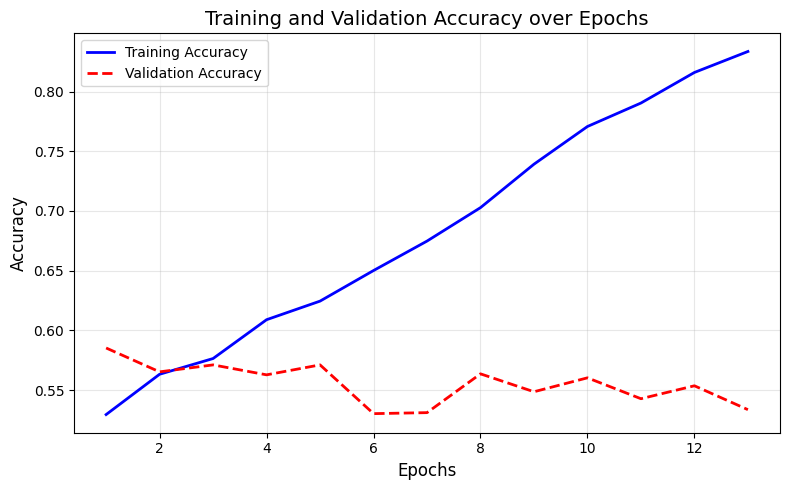

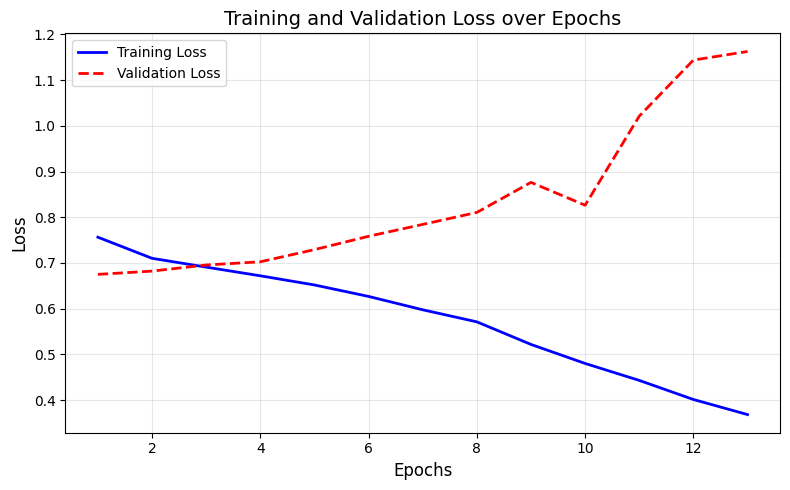

In [30]:
import matplotlib.pyplot as plt
def plot_metric(train_values, val_values, title="Training Progress", ylabel="Metric"):
    """
    Plots a comparison between Training and Validation metrics over epochs.

    Args:
        train_values (list): List of training metric values (e.g., train_loss)
        val_values (list): List of validation metric values (e.g., val_loss)
        title (str): Title of the chart
        ylabel (str): Label for the Y-axis (e.g., "Loss" or "Accuracy")
    """
    epochs = range(1, len(train_values) + 1)

    plt.figure(figsize=(8, 5))

    # Plot Training (Blue solid line)
    plt.plot(epochs, train_values, "b-", linewidth=2, label=f"Training {ylabel}")

    # Plot Validation (Red dashed line)
    plt.plot(epochs, val_values, "r--", linewidth=2, label=f"Validation {ylabel}")

    plt.title(title, fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)  # Light grid for readability

    plt.tight_layout()
    plt.show()


plot_metric(
    train_values=train_accs,
    val_values=val_accs,
    title="Training and Validation Accuracy over Epochs",
    ylabel="Accuracy",
)

plot_metric(
    train_values=train_losses,
    val_values=val_losses,
    title="Training and Validation Loss over Epochs",
    ylabel="Loss",
)